#Requirement and Data loading

In [2]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-eitomu06
  Stored in directory: /tmp/pip-ephem-wheel-cache-kuv4shqy/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [3]:
from keras.datasets import mnist
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import datetime
import matplotlib.pyplot as plt
import sys
import numpy as np
import os
import glob
import imageio
from skimage.transform import resize

%matplotlib inline

Using TensorFlow backend.


In [0]:
%%bash
FILE="apple2orange"

if [[ $FILE != "ae_photos" && $FILE != "apple2orange" && $FILE != "summer2winter_yosemite" &&  $FILE != "horse2zebra" && $FILE != "monet2photo" && $FILE != "cezanne2photo" && $FILE != "ukiyoe2photo" && $FILE != "vangogh2photo" && $FILE != "maps" && $FILE != "cityscapes" && $FILE != "facades" && $FILE != "iphone2dslr_flower" && $FILE != "ae_photos" ]]; then
    echo "Available datasets are: apple2orange, summer2winter_yosemite, horse2zebra, monet2photo, cezanne2photo, ukiyoe2photo, vangogh2photo, maps, cityscapes, facades, iphone2dslr_flower, ae_photos"
    exit 1
fi

URL=https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/$FILE.zip
ZIP_FILE=./datasets/$FILE.zip
TARGET_DIR=./datasets/$FILE
mkdir -p ./datasets
mkdir -p ./saved
wget -N -q $URL -O $ZIP_FILE
unzip -q $ZIP_FILE -d ./datasets/
rm $ZIP_FILE

In [0]:
class DataLoader():
    def __init__(self, dataset_name, img_res=(128, 128)):
        self.dataset_name = dataset_name
        self.img_res = img_res

    def load_data(self, domain, batch_size=1, is_testing=False):
        data_type = "train%s" % domain if not is_testing else "test%s" % domain
        path = glob.glob('./datasets/%s/%s/*' % (self.dataset_name, data_type))

        batch_images = np.random.choice(path, size=batch_size)

        imgs = []
        for img_path in batch_images:
            img = self.imread(img_path)
            if not is_testing:
                img = resize(img, self.img_res)

                if np.random.random() > 0.5:
                    img = np.fliplr(img)
            else:
                img = resize(img, self.img_res)
            imgs.append(img)

        imgs = np.array(imgs)/127.5 - 1.

        return imgs

    def load_batch(self, batch_size=1, is_testing=False):
        data_type = "train" if not is_testing else "val"
        path_A = glob.glob('datasets/%s/%sA/*' % (self.dataset_name, data_type))
        path_B = glob.glob('datasets/%s/%sB/*' % (self.dataset_name, data_type))

        self.n_batches = int(min(len(path_A), len(path_B)) / batch_size)
        total_samples = self.n_batches * batch_size

        # Sample n_batches * batch_size from each path list so that model sees all
        # samples from both domains
        path_A = np.random.choice(path_A, total_samples, replace=False)
        path_B = np.random.choice(path_B, total_samples, replace=False)

        for i in range(self.n_batches-1):
            batch_A = path_A[i*batch_size:(i+1)*batch_size]
            batch_B = path_B[i*batch_size:(i+1)*batch_size]
            imgs_A, imgs_B = [], []
            for img_A, img_B in zip(batch_A, batch_B):
                img_A = self.imread(img_A)
                img_B = self.imread(img_B)

                img_A = resize(img_A, self.img_res)
                img_B = resize(img_B, self.img_res)

                if not is_testing and np.random.random() > 0.5:
                        img_A = np.fliplr(img_A)
                        img_B = np.fliplr(img_B)

                imgs_A.append(img_A)
                imgs_B.append(img_B)

            imgs_A = np.array(imgs_A)/127.5 - 1.
            imgs_B = np.array(imgs_B)/127.5 - 1.

            yield imgs_A, imgs_B

    def imread(self, path):
        return imageio.imread(path, pilmode='RGB').astype(np.float)

#Cycle consistent GAN

In [0]:
def conv_block(layer_input, filters, f_size=4, normalization=True):
    d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
    d = LeakyReLU(alpha=0.2)(d)
    if normalization:
        d = InstanceNormalization()(d)
    return d

def deconv_block(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
    u = UpSampling2D(size=2)(layer_input)
    u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
    if dropout_rate:
        u = Dropout(dropout_rate)(u)
    u = InstanceNormalization()(u)
    u = Concatenate()([u, skip_input])
    return u
        
def build_generator(img_shape,num_filter,num_channels):
    d0 = Input(shape=img_shape)
        
    # Downsampling
    d1 = conv_block(d0, num_filter)
    d2 = conv_block(d1, num_filter * 2)
    d3 = conv_block(d2, num_filter * 4)
    d4 = conv_block(d3, num_filter * 8)
        
    # Upsampling
    u1 = deconv_block(d4, d3, num_filter * 4)
    u2 = deconv_block(u1, d2, num_filter * 2)
    u3 = deconv_block(u2, d1, num_filter)
        
    u4 = UpSampling2D(size=2)(u3)
    output_img = Conv2D(num_channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u4)
        
    return Model(d0, output_img)
        
def build_discriminator(img_shape,num_filter):
    img = Input(shape=img_shape)
        
    d1 = conv_block(img, num_filter, normalization=False)
    d2 = conv_block(d1, num_filter * 2)
    d3 = conv_block(d2, num_filter * 4)
    d4 = conv_block(d3, num_filter * 8)
        
    validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)
        
    return Model(img, validity)

In [0]:
class CycleGAN():
    def __init__(self, img_rows=128, img_cols=128, channels=3, dataset_name='maps'):
        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channels = channels
        self.img_shape = (img_rows, img_cols, channels)
        
        self.dataset_name = dataset_name
        self.data_loader = DataLoader(self.dataset_name, img_res=(self.img_rows, self.img_cols))
        
        if not os.path.isdir('images'):
            os.mkdir('images', 0o755)
        if not os.path.isdir(os.path.join('images', self.dataset_name)):
            os.mkdir(os.path.join('images', self.dataset_name), 0o755)
        
        # Calculate output shape of D 
        patch = int(self.img_rows / 2**4)
        self.disc_patch = (patch, patch, 1)
        
        # Number of filters in the first layer of G and D
        self.gf = 32
        self.df = 64
        
        # control enforcement of cycle-consistency loss
        self.lambda_cycle = 10.0
        self.lambda_id = 0.9 * self.lambda_cycle
        
        optimizer = Adam(0.0002, 0.5)
        
        # discriminators
        self.d_a = build_discriminator(self.img_shape,self.df)
        self.d_b = build_discriminator(self.img_shape,self.df)

        self.d_a.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
        self.d_b.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])

        # generators
        self.g_ab = build_generator(self.img_shape,self.gf,self.channels)
        self.g_ba = build_generator(self.img_shape,self.gf,self.channels)
        
        # Input the images
        img_a = Input(shape=self.img_shape)
        img_b = Input(shape=self.img_shape)
       
        translated_b = self.g_ab(img_a)
        translated_a = self.g_ba(img_b)
        
        # Translate images back to original domain
        recon_a = self.g_ba(translated_b)
        recon_b = self.g_ab(translated_a)
        
        #identity mappig
        img_a_id = self.g_ba(img_a)
        img_b_id = self.g_ab(img_b)
        
        # train only the generators together
        self.d_a.trainable = False
        self.d_b.trainable = False
        
        valid_a = self.d_a(translated_a)
        valid_b = self.d_b(translated_b)
        
        self.combined = Model(inputs=[img_a, img_b], output=[valid_a, valid_b, recon_a, recon_b, img_a_id, img_b_id])
        self.combined.compile(loss=['mse', 'mse', 'mae', 'mae', 'mae', 'mae'],
                             loss_weights=[1, 1, self.lambda_cycle, self.lambda_cycle, self.lambda_id, self.lambda_id], optimizer=optimizer)
        
    
    def sample_images(self, epoch, batch_i):
        r, c = 2, 4

        imgs_a = self.data_loader.load_data(domain="A", batch_size=2, is_testing=True)
        imgs_b = self.data_loader.load_data(domain="B", batch_size=2, is_testing=True)
       
        translated_b = self.g_ab.predict(imgs_a)
        translated_a = self.g_ba.predict(imgs_b)
        
        #reconstr_a = self.g_ba.predict(fake_b)
        #reconstr_b = self.g_ab.predict(fake_a)

        #gen_imgs = np.concatenate([imgs_a, fake_b, reconstr_a, imgs_b, fake_a, reconstr_b])
        gen_imgs = np.concatenate([imgs_a, imgs_b, translated_b, translated_a])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        #titles = ['Original', 'Translated', 'Reconstructed']
        fig, axs = plt.subplots(r, c, figsize=(12,6))
        fig.subplots_adjust(hspace=0, wspace=0)
        cnt = 0
        for i in range(r):
            #axs[i,0].set_title(titles[i])
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%s/%d_%d.png" % (self.dataset_name, epoch, batch_i))
        plt.show()
    
    def train(self, epochs, batch_size=1, sample_interval=50):
        start_time = datetime.datetime.now()
        
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)
        
        for epoch in range(epochs):
            for batch_i, (imgs_a, imgs_b) in enumerate(self.data_loader.load_batch(batch_size)):
                
                # Translate images to opposite domain
                fake_b = self.g_ab.predict(imgs_a)
                fake_a = self.g_ba.predict(imgs_b)
                
                # Train the discriminators (original images = real / translated = Fake)
                da_loss_real = self.d_a.train_on_batch(imgs_a, valid)
                da_loss_fake = self.d_a.train_on_batch(fake_a, fake)
                da_loss = 0.5 * np.add(da_loss_real, da_loss_fake)

                db_loss_real = self.d_b.train_on_batch(imgs_b, valid)
                db_loss_fake = self.d_b.train_on_batch(fake_b, fake)
                db_loss = 0.5 * np.add(db_loss_real, db_loss_fake)

                d_loss = 0.5 * np.add(da_loss, db_loss)
                
                g_loss = self.combined.train_on_batch([imgs_a, imgs_b], [valid, valid, imgs_a, imgs_b, imgs_a, imgs_b])

            if epoch % sample_interval == 0:
                print('epoch: {} generator loss: {} discriminator loss: {}'.format(epoch, g_loss, d_loss))
                self.sample_images(epoch, batch_i)
            if epoch % 33 == 0:
                save_name = 'saved/' + '{}' + str(epoch) + '.h5'
                self.g_ab.save_weights(save_name.format('GAB_weights_'))
                self.g_ba.save_weights(save_name.format('GBA_weights_'))

In [8]:
gan = CycleGAN(dataset_name='apple2orange')

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch: 0 generator loss: [15.530184, 0.8585411, 1.2249708, 0.30878064, 0.3175126, 0.43034685, 0.36784634] discriminator loss: [0.42473024 0.42468262]


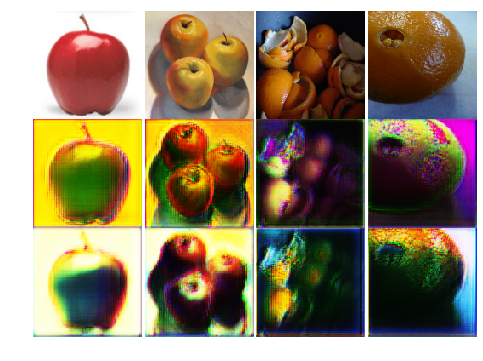

epoch: 5 generator loss: [7.7604027, 0.68526226, 0.66956055, 0.18442357, 0.18570098, 0.14508496, 0.1553966] discriminator loss: [0.3992306  0.38171387]


epoch: 10 generator loss: [6.527337, 0.4807493, 0.5800271, 0.1522815, 0.15616418, 0.13524768, 0.12943053] discriminator loss: [0.34960926 0.3961792 ]


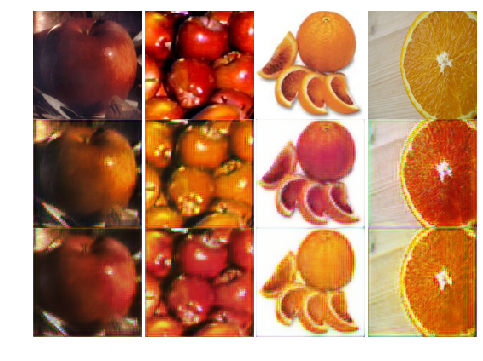

epoch: 15 generator loss: [6.720574, 0.6460656, 0.49775326, 0.16338107, 0.15376419, 0.12707719, 0.14017862] discriminator loss: [0.30157226 0.4744873 ]


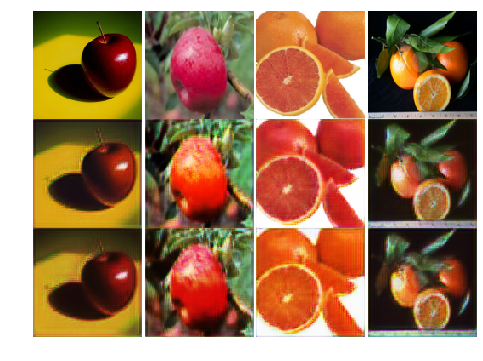

epoch: 20 generator loss: [6.141543, 0.5375801, 0.53721654, 0.1380333, 0.14639015, 0.11757289, 0.12937286] discriminator loss: [0.30293947 0.48602295]


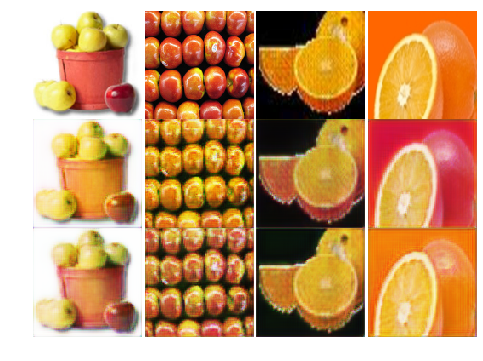

epoch: 25 generator loss: [5.1979713, 0.48354328, 0.49205497, 0.11651718, 0.11729945, 0.10419689, 0.10515946] discriminator loss: [0.25612944 0.5614624 ]


epoch: 30 generator loss: [5.061512, 0.44231382, 0.50491846, 0.12152617, 0.120118946, 0.09811052, 0.09053709] discriminator loss: [0.26216644 0.5899658 ]


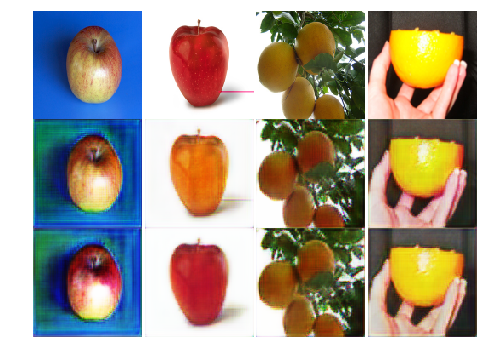

epoch: 35 generator loss: [4.932905, 0.5188989, 0.4683035, 0.11227269, 0.1043889, 0.09903032, 0.09864598] discriminator loss: [0.25082797 0.57910156]


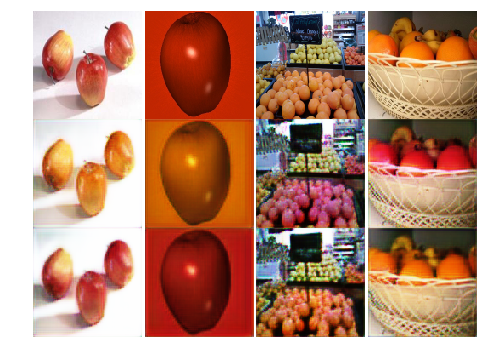

epoch: 40 generator loss: [4.5953946, 0.48875663, 0.46670425, 0.10010749, 0.104579, 0.084249735, 0.09275791] discriminator loss: [0.240515   0.62335205]


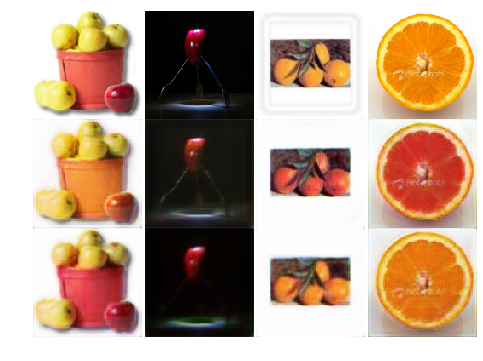

epoch: 45 generator loss: [4.176779, 0.4193483, 0.46185416, 0.09185403, 0.09136621, 0.07968466, 0.082912445] discriminator loss: [0.25900108 0.567749  ]


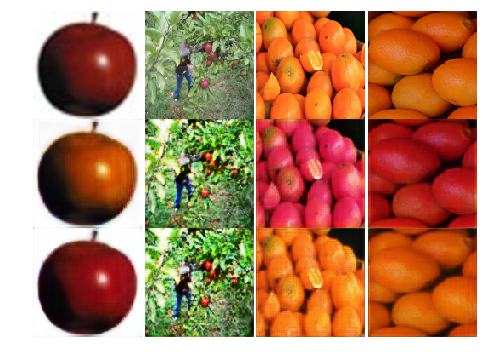

epoch: 50 generator loss: [4.4005866, 0.4766876, 0.49474788, 0.09508163, 0.09961515, 0.07502469, 0.08966235] discriminator loss: [0.26684594 0.5587158 ]


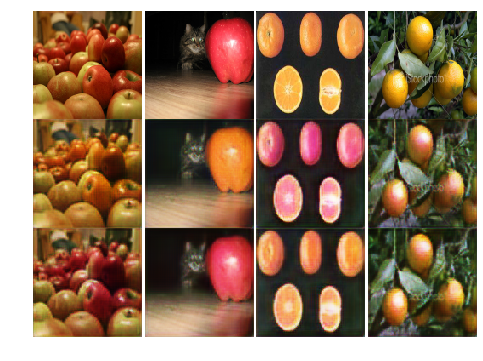

epoch: 55 generator loss: [4.312703, 0.40491942, 0.4750014, 0.09063451, 0.09587699, 0.08443397, 0.08975128] discriminator loss: [0.262397  0.5610962]


epoch: 60 generator loss: [4.1164303, 0.41658455, 0.44452092, 0.087951735, 0.09830445, 0.07536101, 0.07939045] discriminator loss: [0.24678038 0.5732422 ]


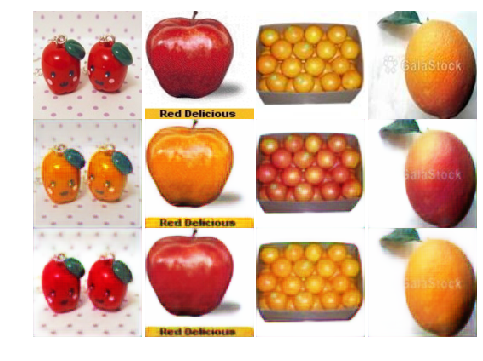

epoch: 65 generator loss: [4.1970577, 0.45282775, 0.44551915, 0.091664955, 0.09599256, 0.07487341, 0.08314166] discriminator loss: [0.23629516 0.6102905 ]


epoch: 70 generator loss: [4.101073, 0.4563771, 0.54748, 0.09096266, 0.0814556, 0.08223981, 0.07031944] discriminator loss: [0.24069592 0.6094971 ]


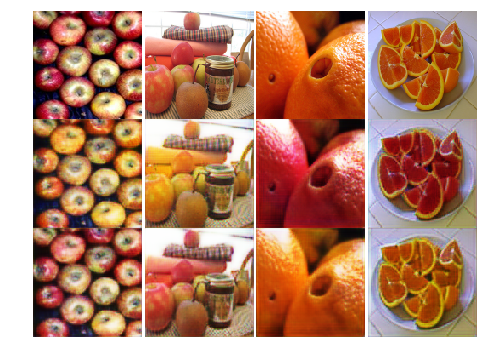

epoch: 75 generator loss: [3.9971871, 0.47523487, 0.4866982, 0.085813135, 0.08474026, 0.0734427, 0.074303985] discriminator loss: [0.2175596  0.65112305]


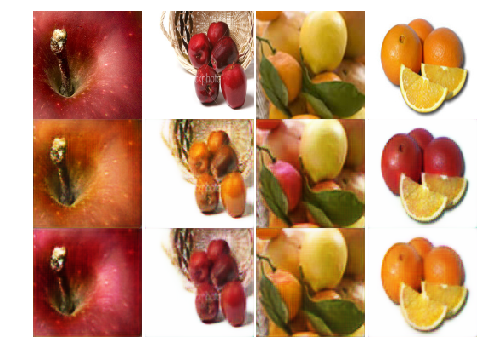

epoch: 80 generator loss: [4.0012946, 0.5457245, 0.47184873, 0.08558904, 0.08358152, 0.07041939, 0.073137924] discriminator loss: [0.2296538  0.61260986]


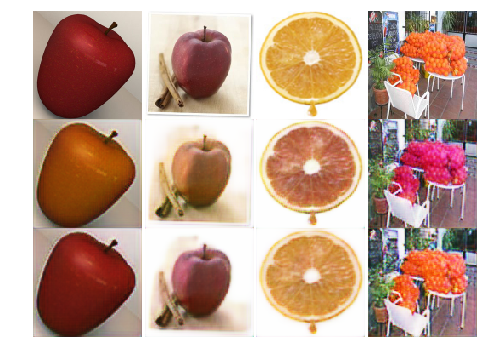

epoch: 85 generator loss: [3.926731, 0.44690898, 0.42587, 0.090926304, 0.08196036, 0.07822326, 0.0690085] discriminator loss: [0.24601072 0.58428955]


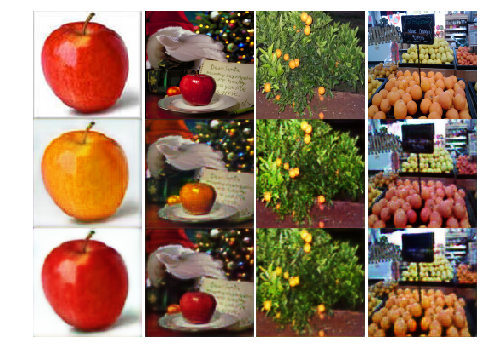

epoch: 90 generator loss: [3.741457, 0.4686764, 0.46909657, 0.074870035, 0.08258875, 0.064166486, 0.07239974] discriminator loss: [0.22122608 0.64886475]


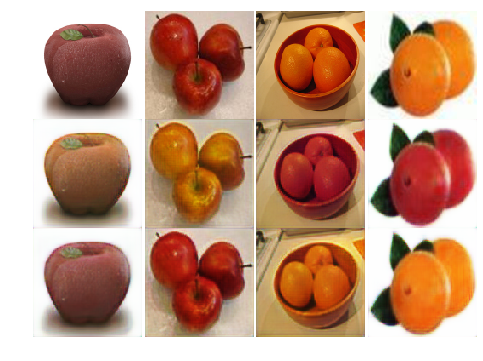

epoch: 95 generator loss: [4.0744505, 0.47577226, 0.44679648, 0.09100677, 0.08999432, 0.074255496, 0.074841306] discriminator loss: [0.24693736 0.58081055]


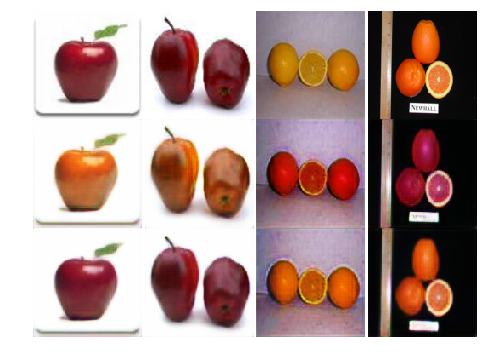

In [0]:
gan.train(epochs=100, batch_size=64, sample_interval=5)

In [0]:
gan.train(epochs=50, batch_size=64, sample_interval=5)

In [17]:
gan.sample_images(90, 0)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [0]:
gan.g_ba.load_weights('GBA_weights_99.h5')
gan.g_ab.load_weights('GAB_weights_99.h5')

In [0]:
gan.sample_images(99, 0)